<div style=float:right><img src="assets/img/appliedai-logo.png" width=100 style="margin: 0px 20px"></img></div>


##### Jonathan Sedar Personal Project
## PyMC3 vs PyStan Comparison
_Spring 2016_

This set of Notebooks and scripts comprise the **pymc3_vs_pystan** personal project by Jonathan Sedar of Applied AI Ltd, written primarily for presentation at the PyData London 2016 Conference.

The project demonstrates hierarchical linear regression using two Bayesian inference frameworks: PyMC3 and PyStan. The project borrows heavily from code written for Applied AI Ltd and is supplied here for educational purposes only. No copyright or license is extended to users.


# 00_BasicInstallTests

#### Confirm that statsmodels, PyMC3, Theano and PyStan (Stan) all execute and behave as expected


+ [Setup](#Setup)
    + [Prepare Data](#Prepare-Data)
    + [Local Functions](#Local-Functions)



# Setup

In [1]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux
# %connect_info

In [38]:
import sys
import regex as re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import patsy as pt
import statsmodels.api as sm

import pymc3 as pm
import theano as thno
import theano.tensor as T 
import pystan

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
np.random.seed(0)

In [34]:
print('Python: {}'.format(sys.version))
print('Recursion limit {}'.format(sys.getrecursionlimit()))
print('theano: {}'.format(thno.__version__))
print('PyMC3: {}'.format(pm.__version__))

Python: 3.5.1 |Continuum Analytics, Inc.| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Recursion limit 10000
theano: 0.8.1
PyMC3: 3.0


## Local Functions

In [39]:
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)     
    return ret_rvs


## Prepare Data

We'll use the Hogg 2010 data available at  https://github.com/astroML/astroML/blob/master/astroML/datasets/hogg2010test.py  
It's a very small dataset so for convenience, it's hardcoded below.

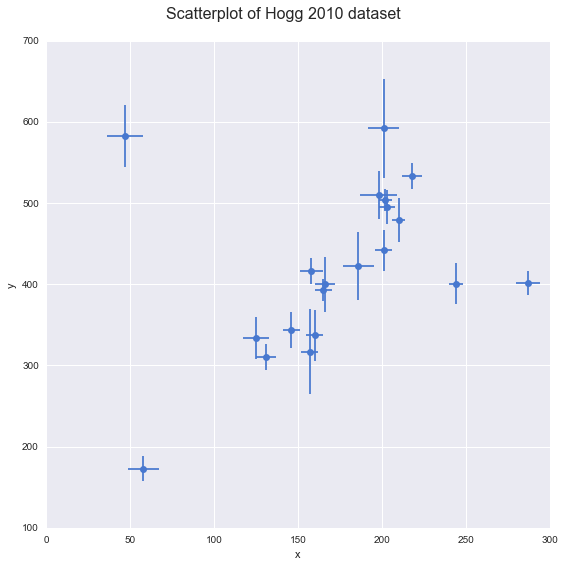

In [20]:
## cut & pasted directly from the fetch_hogg2010test() function in astroml package
## identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])

## for convenience zero-base the 'id' and use as index
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

## scatterplot
g = sns.FacetGrid(dfhogg, size=8)
_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
_ = plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset', fontsize=16)

---

# Create OLS using statsmodels for reference

In [24]:
(mx_en, mx_ex) = pt.dmatrices('y ~ x + 1', dfhogg, return_type='dataframe', NA_action='raise')

In [31]:
smfit = sm.OLS(mx_en, mx_ex).fit()
print(smfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.473
Date:                Tue, 19 Apr 2016   Prob (F-statistic):              0.133
Time:                        18:07:55   Log-Likelihood:                -119.15
No. Observations:                  20   AIC:                             242.3
Df Residuals:                      18   BIC:                             244.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    310.0172     73.000      4.247      0.0

---

# Create OLS using PyMC3

##### Build model

In [28]:
with pm.Model() as mdl_ols:
    
    ## Define very weakly informative Uniform priors to give OLS
    b0 = pm.Uniform('b0_intercept', lower=-1e6, upper=1e6)
    b1 = pm.Uniform('b1_slope', lower=-1e6, upper=1e6)
 
    ## Define linear model
    yest = b0 + b1 * dfhogg['x']
    
    ## Define Normal likelihood with Uniform error
    epsilon = pm.Uniform('epsilon', lower=0, upper=100)
    likelihood = pm.Normal('likelihood', mu=yest, sd=epsilon, observed=dfhogg['y'])


Applied interval-transform to b0_intercept and added transformed b0_intercept_interval to model.
Applied interval-transform to b1_slope and added transformed b1_slope_interval to model.
Applied interval-transform to epsilon and added transformed epsilon_interval to model.


##### Take samples using NUTS

In [29]:
with mdl_ols:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)

    ## take samples
    traces_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS())

 [-----------------100%-----------------] 2000 of 2000 complete in 7.4 sec

##### View traceplots

/Users/jon/anaconda/envs/pymc3_vs_pystan/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


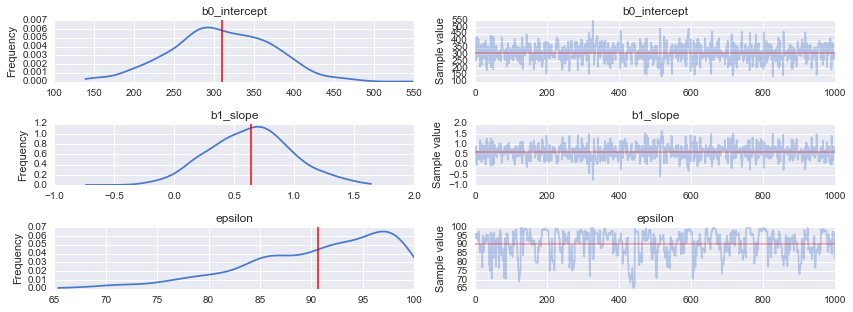

In [40]:
rvs = [rv.name for rv in strip_derived_rvs(mdl_ols.unobserved_RVs)]
_ = pm.traceplot(traces_ols[-1000:], varnames=rvs, figsize=(12, len(rvs)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces_ols[-1000:]).iterrows()})

---

# Create OLS using PyStan

---
**Applied AI Ltd &copy; 2016**  
<a href='http://www.applied.ai'>applied.ai</a>